In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 
df = df.set_index('timestamp')


In [5]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42+00:00,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44+00:00,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46+00:00,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48+00:00,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [6]:
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0


In [7]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [8]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


In [9]:
ip_df = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_count'})
ip_df2 = pd.DataFrame(df.ip.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'ip', 'ip': 'ip_proba'})
ip_df = ip_df.merge(ip_df2)


# see those where rate < 1% 
ip_df[ip_df.ip_proba < .01]


,ip,ip_count,ip_proba
4,24.26.242.9,21,0.001502
5,68.201.219.223,21,0.001502
6,35.175.171.137,2,0.000143
7,70.121.214.34,2,0.000143
8,52.87.230.102,2,0.000143
9,35.174.209.2,1,0.000072
10,52.91.30.150,1,0.000072
11,34.229.70.250,1,0.000072
12,97.105.15.120,1,0.000072
13,54.172.14.223,1,0.000072


In [10]:
df.ip.value_counts()

97.105.19.58      11999
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
24.26.242.9          21
68.201.219.223       21
35.175.171.137        2
70.121.214.34         2
52.87.230.102         2
35.174.209.2          1
52.91.30.150          1
34.229.70.250         1
97.105.15.120         1
54.172.14.223         1
54.145.52.184         1
52.90.165.200         1
3.92.201.136          1
3.88.129.158          1
95.31.16.121          1
45.23.250.16          1
95.31.18.119          1
34.207.64.242         1
Name: ip, dtype: int64

In [11]:
df.groupby('ip').count().sort_values(['size'], ascending=False)

,request_method,status,size,destination,request_agent,size_mb
ip,,,,,,
97.105.19.58,11999,11999,11999,17,11999,11999
173.173.113.51,1059,1059,1059,0,1059,1059
72.181.113.170,613,613,613,2,613,613
72.181.105.81,246,246,246,5,246,246
68.201.219.223,21,21,21,0,21,21
24.26.242.9,21,21,21,0,21,21
35.175.171.137,2,2,2,0,2,2
52.87.230.102,2,2,2,0,2,2
70.121.214.34,2,2,2,1,2,2


In [12]:
df.groupby(['ip', 'status']).size()

ip              status
173.173.113.51  200        1059
24.26.242.9     200          21
3.88.129.158    200           1
3.92.201.136    200           1
34.207.64.242   200           1
34.229.70.250   200           1
35.174.209.2    200           1
35.175.171.137  200           2
45.23.250.16    200           1
52.87.230.102   200           2
52.90.165.200   200           1
52.91.30.150    200           1
54.145.52.184   200           1
54.172.14.223   200           1
68.201.219.223  200          21
70.121.214.34   200           2
72.181.105.81   200         246
72.181.113.170  200         611
                499           2
95.31.16.121    301           1
95.31.18.119    200           1
97.105.15.120   301           1
97.105.19.58    200       11985
                499          14
dtype: int64

In [13]:
df.request_method.value_counts()

GET /api/v1/sales HTTP/1.1                      12403
GET /api/v1/items HTTP/1.1                       1065
GET /api/v1/stores HTTP/1.1                       229
GET / HTTP/1.1                                    107
GET /documentation HTTP/1.1                       100
GET /favicon.ico HTTP/1.1                          26
GET /api/v1//api/v1/items HTTP/1.1                 11
GET /api/v1/items/api/v1/items HTTP/1.1             7
GET /api/v1/items/next_page HTTP/1.1                5
GET /api/v1/ HTTP/1.1                               4
GET /api/v1/itemsitems HTTP/1.1                     3
GET /api/v1/store HTTP/1.1                          3
GET /api/v1/sales/HTTP/1.1                          3
GET /api/v1/sales/ HTTP/1.1                         3
GET /api/v1items HTTP/1.1                           2
GET /api/v1/helloclass! HTTP/1.1                    1
GET /api/v1/items&page=0 HTTP/1.1                   1
GET /api/v1/items/HTTP/1.1                          1
GET /api/v1 HTTP/1.1        

In [14]:

def ip_statistics(df):
    '''
    
    '''
    ip_counts = (
    pd.DataFrame(df.ip.value_counts(ascending=False))
    .reset_index()
    .rename(index=str,
            columns={'index': 'ip',
                    'ip': 'ip_count'})
    )


    ip_probabilities = (
    pd.DataFrame(df.ip.value_counts(normalize=True))
    .reset_index()
    .rename(index=str,
            columns={'index': 'ip',
                    'ip': 'ip_probability'})
    )
    
    ip_df = ip_counts.merge(ip_probabilities)
    return ip_df

ip_statistics(df)

,ip,ip_count,ip_probability
0,97.105.19.58,11999,0.858420
1,173.173.113.51,1059,0.075762
2,72.181.113.170,613,0.043855
3,72.181.105.81,246,0.017599
4,24.26.242.9,21,0.001502
5,68.201.219.223,21,0.001502
6,35.175.171.137,2,0.000143
7,70.121.214.34,2,0.000143
8,52.87.230.102,2,0.000143
9,35.174.209.2,1,0.000072


In [15]:
def ip_status_probabilities(df):
    '''
    
    '''
    status_given_ip = (
        
        (df.groupby(['ip', 'status']).size()
        / df.groupby(['ip']).status.size())
        .reset_index().
        rename(columns={0:'prob_status_given_ip'})
    )
    
    ip_status_count = (

        pd.DataFrame(df.groupby(by=['ip', 'status']).size())
        .reset_index()
        .rename(columns={0:'ip_status_count'})
    )
    
    ip_status = ip_status_count.merge(status_given_ip, on=['ip', 'status'])
    return ip_status

ip_status_probabilities(df)

,ip,status,ip_status_count,prob_status_given_ip
0,173.173.113.51,200,1059,1.000000
1,24.26.242.9,200,21,1.000000
2,3.88.129.158,200,1,1.000000
3,3.92.201.136,200,1,1.000000
4,34.207.64.242,200,1,1.000000
5,34.229.70.250,200,1,1.000000
6,35.174.209.2,200,1,1.000000
7,35.175.171.137,200,2,1.000000
8,45.23.250.16,200,1,1.000000
9,52.87.230.102,200,2,1.000000


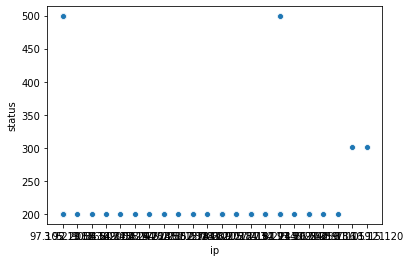

In [20]:
sns.scatterplot(df.ip,df.status)

In [17]:
df


,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42+00:00,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246
...,...,...,...,...,...,...,...
2019-04-17 12:55:14+00:00,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510166,NaN,python-requests/2.21.0,0.486532
2019-04-21 10:02:41+00:00,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,1153005,NaN,python-requests/2.21.0,1.099591
2019-04-17 19:36:41+00:00,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,1005,NaN,python-requests/2.21.0,0.000958


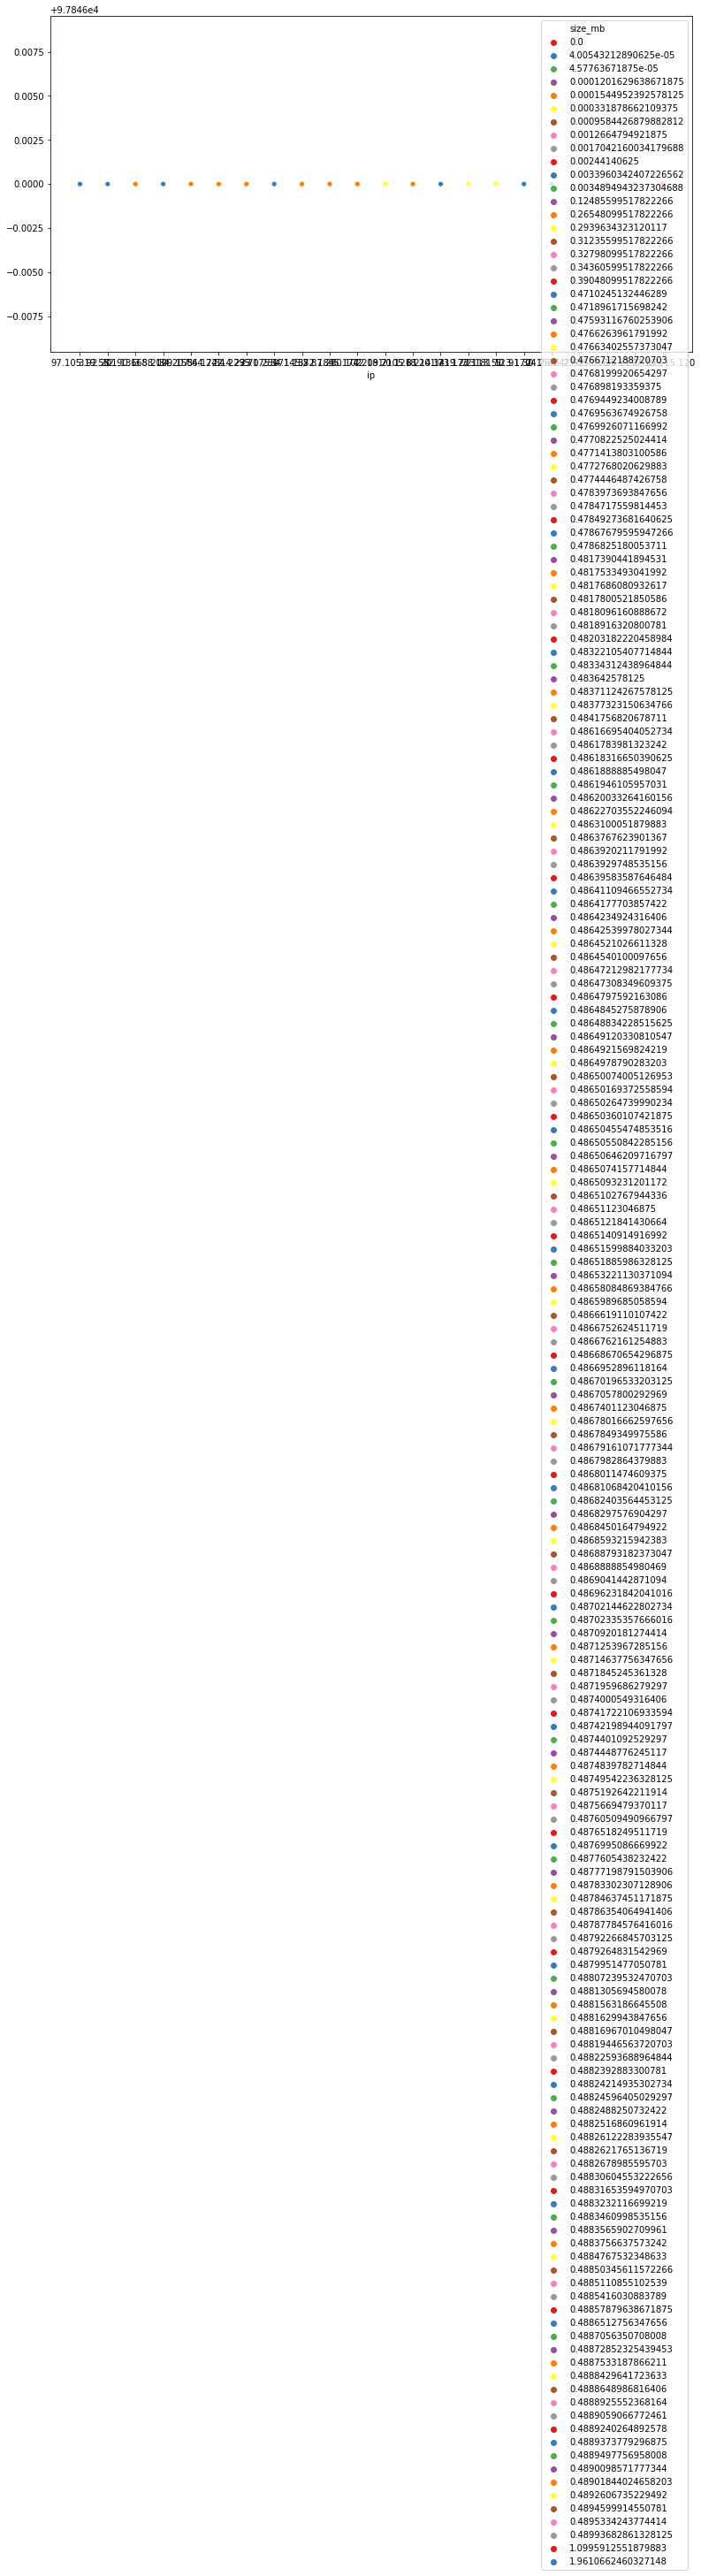

In [23]:
plt.figure(figsize=(13, 7))
sns.scatterplot(df.ip,
                df.size,
                hue=df.size_mb,
                palette='Set1')